# Motif Analysis

In [1]:
library(Signac)
library(Seurat)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Mmusculus.UCSC.mm10)
library(patchwork)
set.seed(1234)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching SeuratObject


Attaching package: 'Seurat'


The following object is masked from 'package:Signac':

    FoldChange




Loading required package: BSgenome

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Pos

## 0. Load the data

In [2]:
brain <- readRDS("./adult_mouse_brain/Outputs/brain_coaccs.rds")

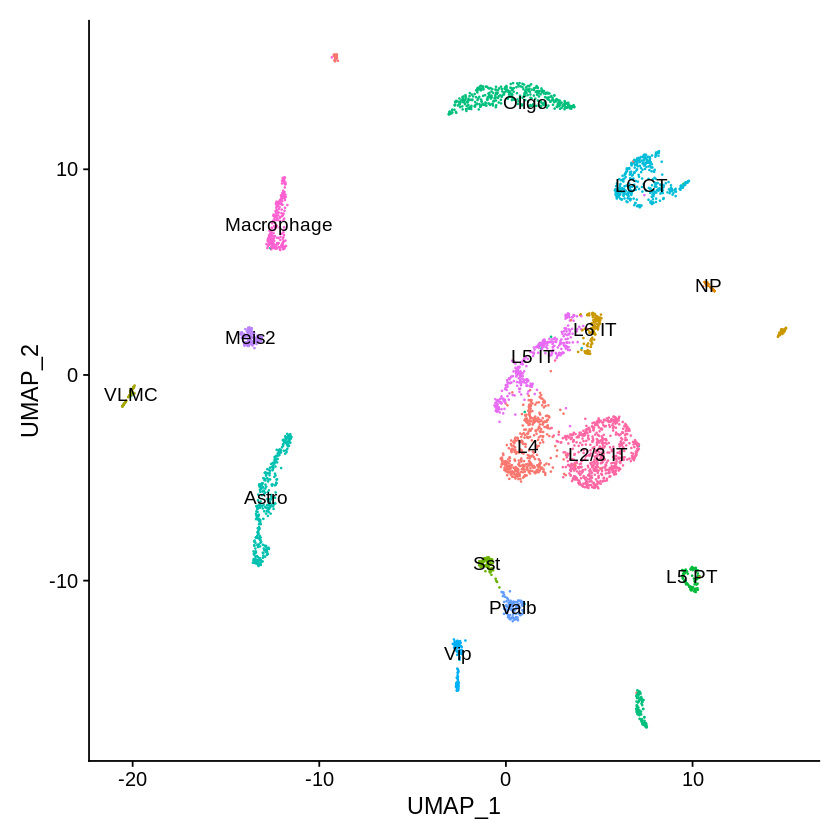

In [3]:
p1 <- DimPlot(brain, label = TRUE, pt.size = 0.1) + NoLegend()
p1

## 1. Add motif information

In [4]:
DefaultAssay(brain) <- 'ATAC'

#Get the list of motif position frequency matrices from JASPAR Database. 
#(we can also use chromVARmotifs instead of JASPAR)

#10090 Mus musculus
#7742 Vertebrata

pfm <- getMatrixSet(x = JASPAR2020,
                    opts = list(species = 10090, all_versions = FALSE)) #check taxonomy ID for the respective species

# add motif information
brain <- AddMotifs(object = brain,
                   genome = BSgenome.Mmusculus.UCSC.mm10,
                   pfm = pfm)

Building motif matrix

Finding motif positions

Creating Motif object



## 2. Find overrepresented motifs

We can search for DNA motifs that are overrepresented in a set of peaks that are differentially accessible between cell types, this is to identify potentially important cell-type-specific regulatory sequences.

First, we need to find differentially accessible peaks between the two groups of cells or clusters like in the previous notebook.

In [5]:
da_peaks <- FindMarkers(
  object = brain,
  ident.1 = 'Pvalb',
  ident.2 = 'Sst',
  only.pos = TRUE,
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

# get top differentially accessible peaks
top.da.peak <- rownames(da_peaks[da_peaks$p_val < 0.005, ])

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

By default, the set of background peaks is matched for GC content, but we can also restrict the background peaks to the accessible peaks in the groups of cells we are comparing.

The `AccessiblePeaks()` function finds a set of peaks that are open in a subset of cells. In the function, accessible peaks are peaks that have more than 10 counts overall cells.

We can use this function to first restrict the set of possible background peaks to those peaks that were open in the set of cells that we are comparing, and then create a GC-content-matched set of peaks from this larger set using `MatchRegionStats()`.

In [6]:
# find peaks open in Pvalb or Sst cells
open.peaks <- AccessiblePeaks(brain, idents = c("Pvalb", "Sst")) 

# match the overall GC content in the peak set
meta.feature <- GetAssayData(brain, assay = "ATAC", slot = "meta.features")
peaks.matched <- MatchRegionStats(
  meta.feature = meta.feature[open.peaks, ],
  query.feature = meta.feature[top.da.peak, ],
  n = 50000
)

Matching GC.percent distribution



*peaks.matched can be used as the background peak set by setting background=peaks.matched in `FindMotifs()`.*

`FindMotifs()` finds motifs over-represented in a given set of genomic features. Computes the number of features containing the motif (observed) and compares this to the total number of features containing the motif (background) using the hypergeometric test.

We then perform a hypergeometric test to test the probability of observing the motif at the given frequency by chance, comparing with the background set of peaks matched for GC content.

In [7]:
# test enrichment
enriched.motifs <- FindMotifs(
  object = brain,
  features = top.da.peak
)

Selecting background regions to match input sequence characteristics

Matching GC.percent distribution

Testing motif enrichment in 2436 regions



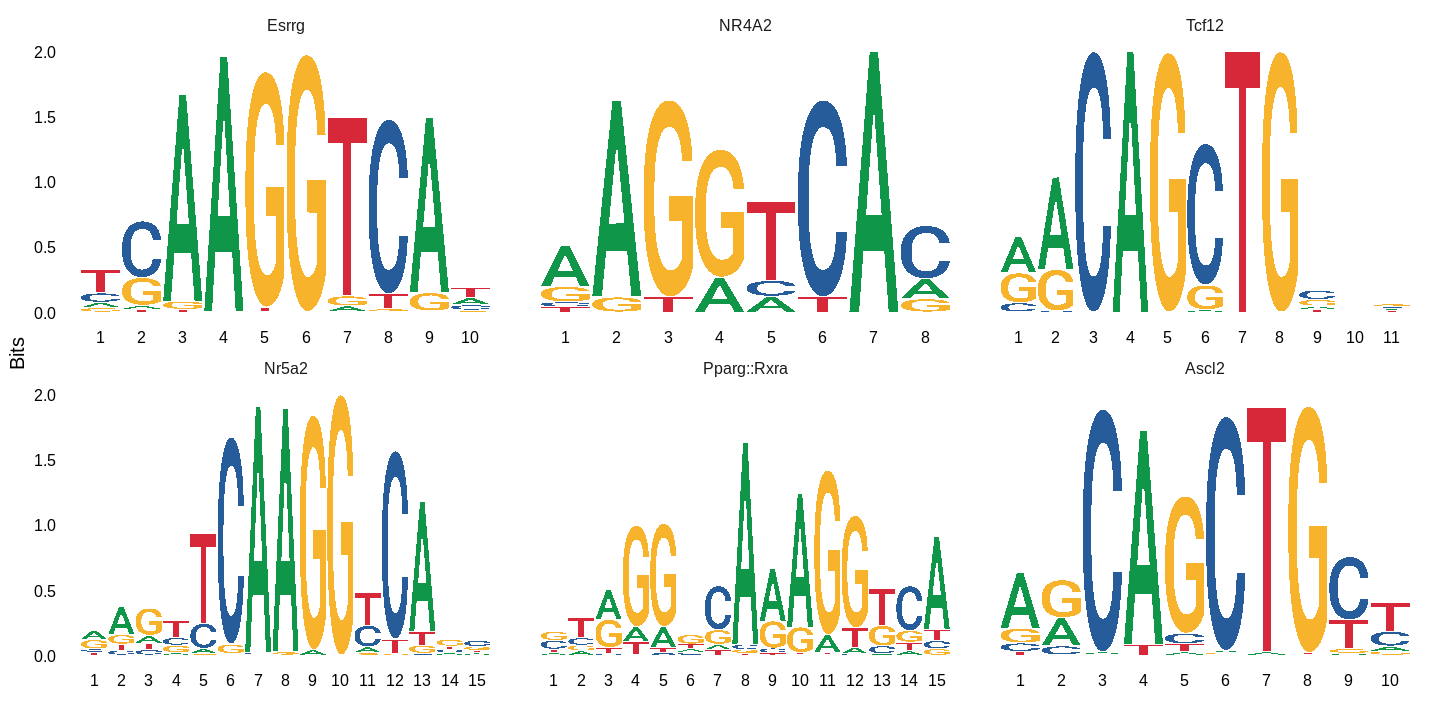

In [8]:
#plot the weight matrices for the motifs
options(repr.plot.width=12, repr.plot.height=6)

MotifPlot(
  object = brain,
  motifs = head(rownames(enriched.motifs)))

## 3. Computing motif activities

We can also compute a per-cell motif activity score by running chromVAR. This allows us to visualize motif activities per cell, and also provides an alternative method of identifying differentially-active motifs between cell types.

ChromVAR identifies motifs associated with variability in chromatin accessibility between cells. See the <a href=https://www.nature.com/articles/nmeth.4401>chromVAR paper</a> for details.

Quick summary:
1. Estimates raw accessibility deviation: # of fragments that map to peaks containing motif - expected # fragments (based on average od cells).
2. Creates background peak sets for each annotation. The sets have the same number of peaks matched for GC content and average accessibility.
3. Raw accessibility deviations for background peak sets are used to compute a biased-corrected deviation and z-score for gene annotation and cell.
This provides a differential measure of the gain or loss of accessibility of a given genomic annotationrealtive to the average cell profile.

Motif activities = deviations in chromatin accessibility across the set of regions.

For each motif there is a value representing how different the accessibility for peaks with that motif is from the expectation based on all cells being equal. Corrected for biases.

In [9]:
brain <- RunChromVAR(
  object = brain,
  genome = BSgenome.Mmusculus.UCSC.mm10
)

Computing GC bias per region

Selecting background regions

Computing deviations from background

Constructing chromVAR assay



In [10]:
brain

An object of class Seurat 
184288 features across 3512 samples within 4 assays 
Active assay: ATAC (157203 features, 157203 variable features)
 3 other assays present: ACTIVITY, RNA, chromvar
 2 dimensional reductions calculated: lsi, umap

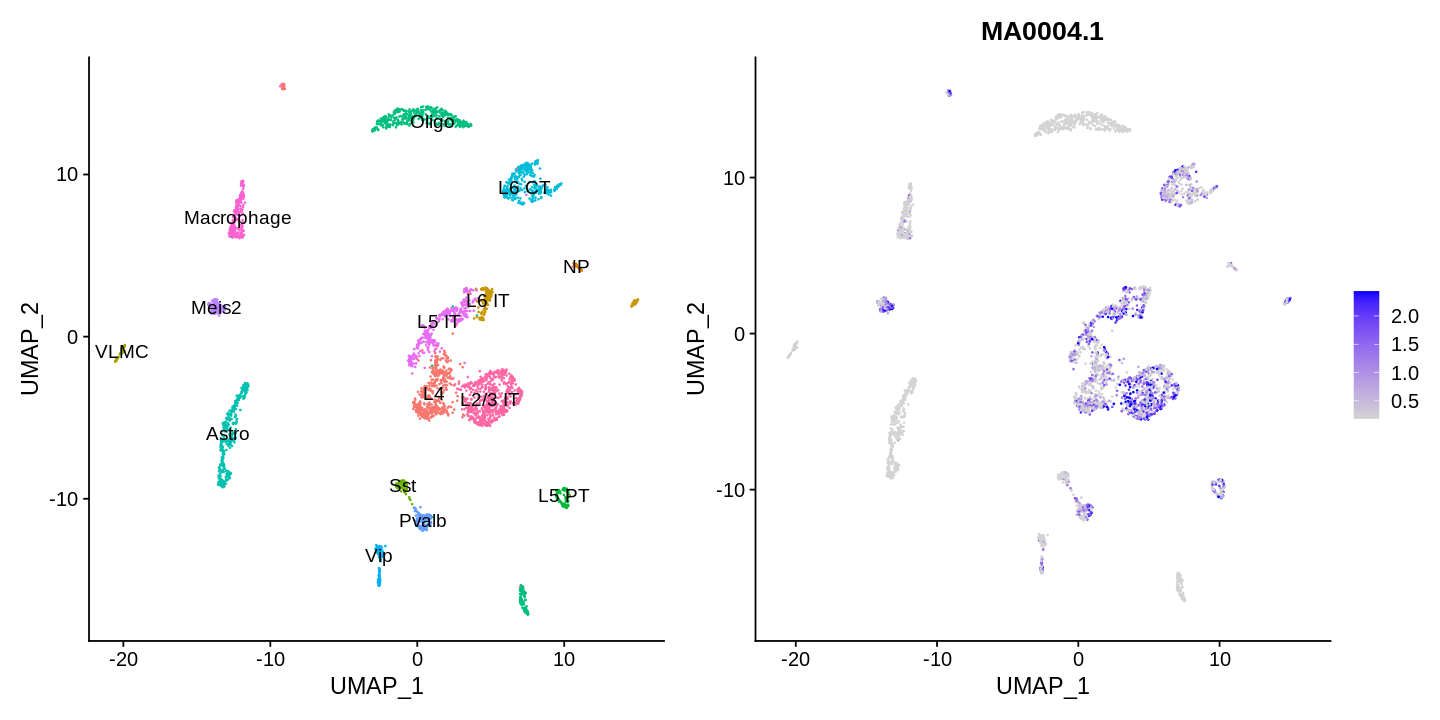

In [11]:
DefaultAssay(brain) <- 'chromvar'

# look at the activity of Arnt (see JASPAR for correspondence)
p2 <- FeaturePlot(
  object = brain,
  features = "MA0004.1",
  min.cutoff = 'q10',
  max.cutoff = 'q90',
  pt.size = 0.1
)
p1 + p2

We can also directly test for differential activity scores between cell types. This tends to give similar results as performing an enrichment test on differentially accessible peaks between the cell types (shown above).

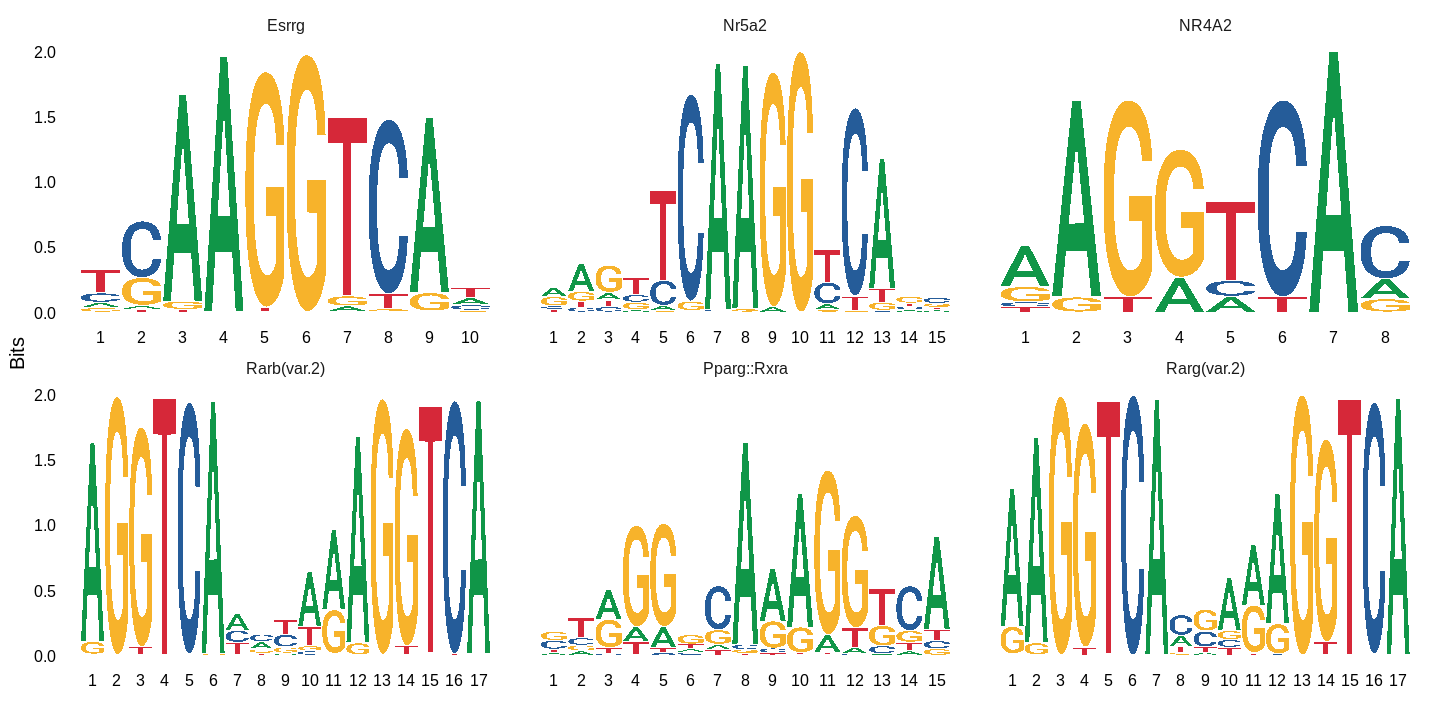

In [12]:
differential.activity <- FindMarkers(
  object = brain,
  ident.1 = 'Pvalb',
  ident.2 = 'Sst',
  only.pos = TRUE,
  test.use = 'LR',
  latent.vars = 'nCount_ATAC'
)

MotifPlot(
  object = brain,
  motifs = head(rownames(differential.activity)),
  assay = 'ATAC'
)


In [13]:
saveRDS(brain, file = "./adult_mouse_brain/Outputs/brain_motif.rds")